---
title: Visualizing SPI distance as compared to NCBI taxonomic category

author: Benjamin Doran

---

In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

In [2]:
using Muon
using LinearAlgebra
using Distances
using Statistics
using StatsPlots
using StatsBase
using Random: shuffle
using SPI

In [3]:
UP7047_NCOLS = 10117

10117

## Setup

In [4]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))

MuData object 673 ✕ 11296
└ metabolites_foldchange
  AnnData object 673 ✕ 38
└ metabolites_millimolar
  AnnData object 673 ✕ 10
└ oggs
  AnnData object 673 ✕ 11248

In [5]:
pdir = plotsdir("BB673distanceplots_taxonomy") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy"

In [6]:
keys(biobank["oggs"].obsm)

KeySet for a Muon.AlignedMapping{Tuple{1 => 1}, String, AnnData} with 1 entry. Keys:
  "inferredLSVs_UP7047"

In [7]:
SPImtx = biobank["oggs"].obsp["inferredSPIdist_UP7047"][:, :] ./ UP7047_NCOLS;

In [8]:
bbtaxa = biobank.obs[:,1:6];

In [9]:
# 4 Main metabolites  ["Acetate_mM", "Butyrate_mM", "Propionate_mM", "Succinate_mM"]
# metabolitedistance = Distances.pairwise(Euclidean(), biobank["metabolites_millimolar"].X[:, 1:4]');
# metabolitedistancerel = Distances.pairwise(Euclidean(), biobank["metabolites_foldchange"].X[:, :]');
# metabolitedistance_mM = Distances.pairwise(Euclidean(), biobank["metabolites_millimolar"].X[:, :]');

taxanomicdistance = pairwise(eachrow(Matrix(bbtaxa)[:,6:-1:1])) do a, b
    x = findfirst(a .== replace(b, ""=>"missing"))
    x === nothing ? 6 : x-1
end;

In [10]:
oggeuclideandistance = Distances.pairwise(Euclidean(), biobank["oggs"].X[:, :]')
BBusv = svd(biobank["oggs"].X[:, :])
BBsvdeuclideandistance = Distances.pairwise(Euclidean(), BBusv.U[:, 1:10]');
UPsvdeuclideandistance = Distances.pairwise(Euclidean(), biobank["oggs"].obsm["inferredLSVs_UP7047"][:, 1:10]');
BBSPImtx = calc_spi_mtx(BBusv.U, BBusv.S, getintervals(BBusv.S)) ./ size(BBusv.V,1);

In [11]:
taxaranklabels = string.([:phylum :class :order :family :genus :species])
taxarankcolors = [:grey :red :pink :orange :lightblue :green :aqua]|> reverse;

In [12]:
uppertriangle = triu(trues(673, 673), 1);

## Specific heatmap of uniformis & gnavus metabolite profiles

In [13]:
r_idxs = occursin.("gnavus", biobank.obs.species) |> findall
popat!(r_idxs, occursin.("MSK.8.22", biobank.obs_names[r_idxs]) |> findfirst) # outlier sample
b_idxs = occursin.("uniformis", biobank.obs.species) |> findall;
# popat!(b_vulgatus_idxs, occursin.("MSK.7.24", biobank.obs_names[b_vulgatus_idxs]) |> findfirst) # contaminated sample
donorid = biobank.obs_names |>
    v -> split.(v, ".") |>
    v -> getindex.(v, 2) |>
    v -> parse.(Int,v)

b_idxs = b_idxs[sortperm(donorid[b_idxs])]
r_idxs = r_idxs[sortperm(donorid[r_idxs])]

br_idxs = union(b_idxs,  r_idxs);

In [14]:
bb673mm_buniformis = biobank["metabolites_millimolar"].layers["raw"][:,[4,1,2,3]][b_idxs, :];


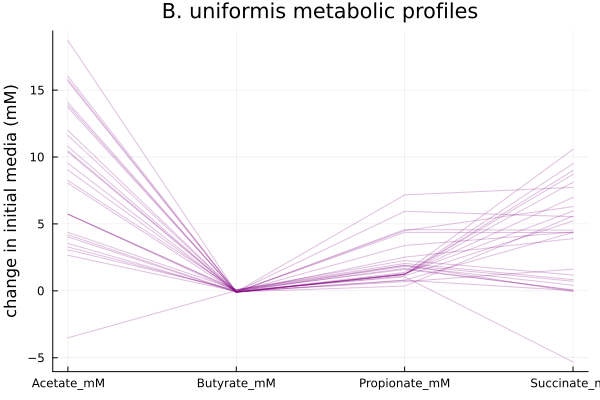

In [15]:
plot(bb673mm_buniformis', 
    title="B. uniformis metabolic profiles",
    ylabel="change in initial media (mM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [16]:
bb673mm_rgnavus = biobank["metabolites_millimolar"].layers["raw"][:,[4,1,2,3]][r_idxs, :];

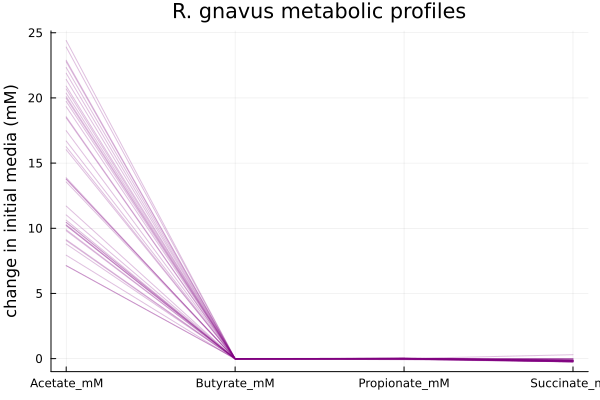

In [17]:
plot(bb673mm_rgnavus', 
    title="R. gnavus metabolic profiles",
    ylabel="change in initial media (mM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [18]:
rownames = biobank.obs_names[br_idxs[[14, 23, 40, 49]]]

4-element Vector{String}:
 "MSK.18.77_Bacteroides_uniformis"
 "MSK.19.4_Bacteroides_uniformis"
 "MSK.15.54_Ruminococcus_gnavus"
 "MSK.22.24_Ruminococcus_gnavus"

In [19]:
colnames=biobank["metabolites_millimolar"].var_names[[4,1,2,3]]

4-element Vector{String}:
 "Acetate_mM"
 "Butyrate_mM"
 "Propionate_mM"
 "Succinate_mM"

In [20]:
pltmtx = vcat(bb673mm_buniformis, bb673mm_rgnavus)[[14, 23, 40, 49], :]

4×4 Matrix{Float64}:
 15.665  -0.1     4.5      6.295
 16.035  -0.09    4.575    4.53
 19.735  -0.02   -0.0425  -0.2425
 17.485  -0.005   0.0175  -0.1475

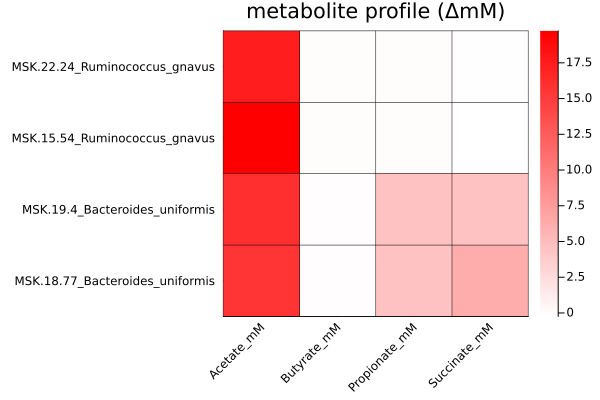

In [25]:
plot(
    title="metabolite profile (ΔmM)",
    yticks=(1:4, rownames), 
    xticks=(1:4, colnames),
    xrotation=45,
    bottommargin=5Plots.Measures.mm,
    )
heatmap!(pltmtx, c=[:white, :red])
hline!(collect(1:4) .+ .5, c=:black, lw=.5, label="")
vline!(collect(1:4) .+ .5, c=:black, lw=.5, label="")

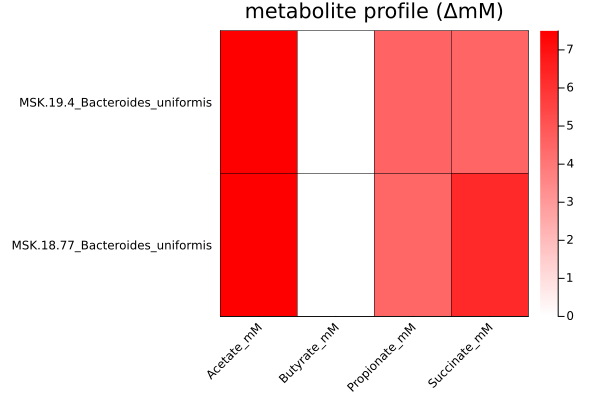

In [22]:
plot(
    title="metabolite profile (ΔmM)",
    yticks=(1:4, rownames[1:2]), 
    xticks=(1:4, colnames),
    xrotation=45,
    bottommargin=5Plots.Measures.mm,
    framestyle=:box,
    )
heatmap!(pltmtx[1:2, :], c=[:white, :red], clims=(0, 7.5))
hline!([1.5], c=:black, lw=.5, label="")
vline!([1.5, 2.5, 3.5], c=:black, lw=.5, label="")

In [ ]:
savefig(joinpath(pdir, "metprofile_2strains_uniformis-uniformis.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots/metprofile_2strains_uniformis-uniformis.pdf"

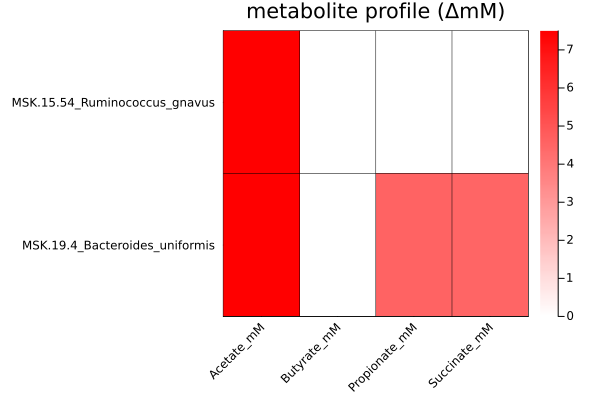

In [ ]:
plot(
    title="metabolite profile (ΔmM)",
    yticks=(1:4, rownames[2:3]), 
    xticks=(1:4, colnames),
    xrotation=45,
    bottommargin=5Plots.Measures.mm,
    framestyle=:box,
    )
heatmap!(pltmtx[2:3, :], c=[:white, :red], clims=(0., 7.5))
hline!([1.5], c=:black, lw=.5, label="")
vline!([1.5, 2.5, 3.5], c=:black, lw=.5, label="")

In [ ]:
savefig(joinpath(pdir, "metprofile_2strains_gnavus-uniformis.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots/metprofile_2strains_gnavus-uniformis.pdf"

## Adams plot - metabolite profiles

In [ ]:
bmask = biobank.obs.phylum .== "Bacteroidetes"
fmask = biobank.obs.phylum .== "Firmicutes";

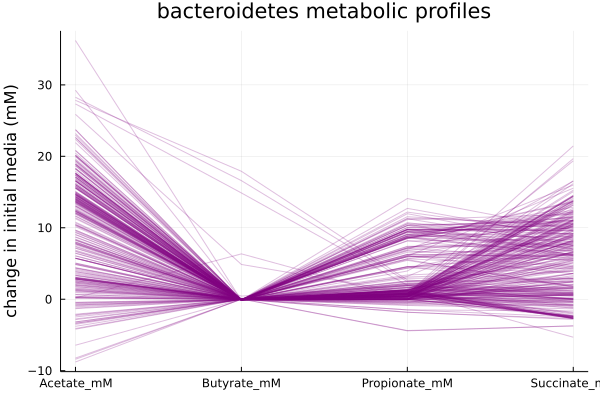

In [ ]:
bb673mm = biobank["metabolites_millimolar"].layers["raw"][:,[4,1,2,3]][bmask, :];
plot(bb673mm', 
    title="bacteroidetes metabolic profiles",
    ylabel="change in initial media (mM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [ ]:
savefig(joinpath(pdir, "bacteroidetes_metabolicprofiles_raw-deltamM.pdf"))

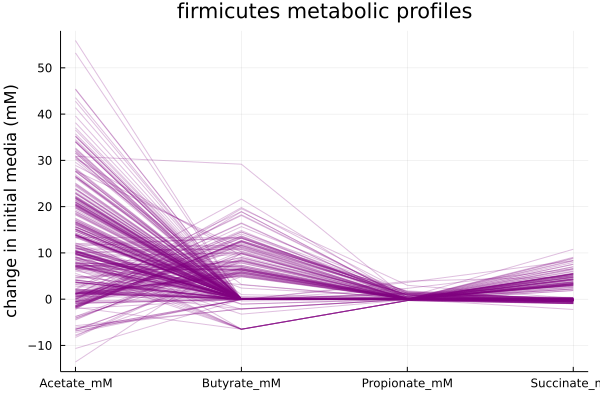

In [ ]:
bb673mm = biobank["metabolites_millimolar"].layers["raw"][:,[4,1,2,3]][fmask, :];
plot(bb673mm', 
    title="firmicutes metabolic profiles",
    ylabel="change in initial media (mM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [ ]:
savefig(joinpath(pdir, "firmicutes_metabolicprofiles_raw-deltamM.pdf"))

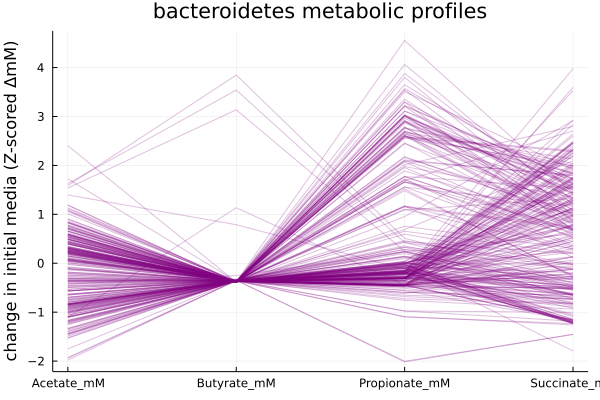

In [ ]:
bb673mm = biobank["metabolites_millimolar"].X[:,[4,1,2,3]][bmask, :];
plot(bb673mm', 
    title="bacteroidetes metabolic profiles",
    ylabel="change in initial media (Z-scored ΔmM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [ ]:
savefig(joinpath(pdir, "bacteroidetes_metabolicprofiles.pdf"))

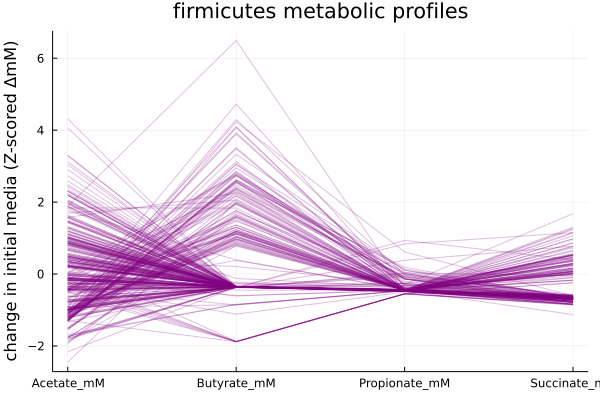

In [ ]:
bb673mm = biobank["metabolites_millimolar"].X[:,[4,1,2,3]][fmask, :];
plot(bb673mm', 
    title="firmicutes metabolic profiles",
    ylabel="change in initial media (Z-scored ΔmM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [ ]:
savefig(joinpath(pdir, "firmicutes_metabolicprofiles.pdf"))

## conflated pairs violin plots

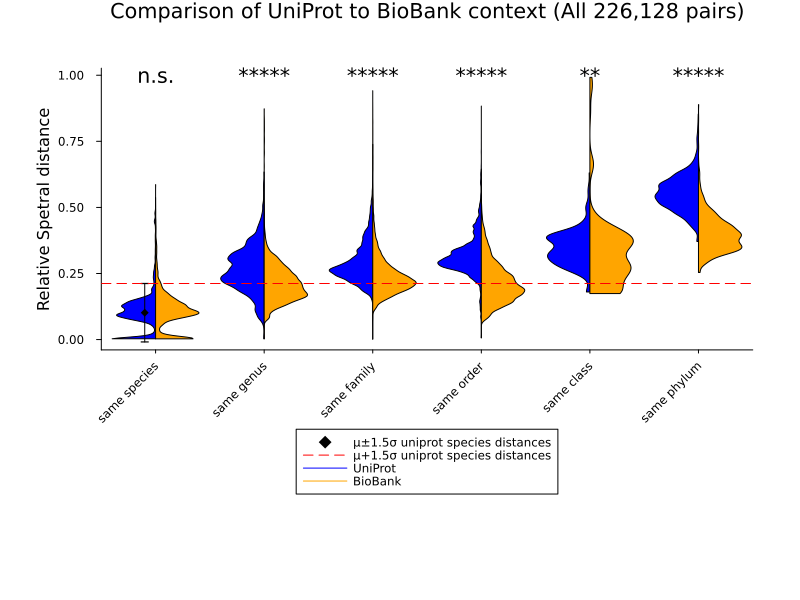

In [100]:
n = 6
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,600), 
    title="Comparison of UniProt to BioBank context (All 226,128 pairs)", 
    ylabel="Relative Spetral distance", 
    tickdirection=:out,
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:n, labels[1:n]),
    xlims=(.5, n +.5),
    xrotation=45,
    legend=:outerbottom,
    grid=false,
)
xdata = taxanomicdistance[uppertriangle]
ydata1 = (SPImtx ./ maximum(SPImtx))[uppertriangle]
ydata2 = (BBSPImtx ./ maximum(BBSPImtx))[uppertriangle]
for i in 0:n
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata1[mask],
        label="",
        c=:blue, 
        side=:left)
    violin!(xdata[mask].+1, ydata2[mask],
        label="",
        c=:orange, 
        side=:right)
end
allspeciesdists = ydata1[xdata.==0]
allspeciesdists2 = ydata2[xdata.==0]
scatter!([.9], [mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, label="μ±1.5σ uniprot species distances", shape=:diamond)
# scatter!([1.1], [mean(allspeciesdists2)], yerror=1.5std(allspeciesdists2), c=:black,  shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, label="μ+1.5σ uniprot species distances", linestyle=:dash)
# hline!([mean(allspeciesdists2)+1.5std(allspeciesdists2)], c=:orange, linestyle=:dash)
plot!([0 0], c=[:blue :orange], label=["UniProt" "BioBank"])
annotate!(1:6, ones(6), ["n.s.", "*****", "*****", "*****", "**", "*****"], fontsize=5)
plot!()

In [101]:
savefig(joinpath(pdir, "SPIdistUPvsSPIdistBB_splitbyNCBItaxonomy_groupedviolin.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy/SPIdistUPvsSPIdistBB_splitbyNCBItaxonomy_groupedviolin.pdf"

## KS test of each distribution

In [32]:
using HypothesisTests

In [33]:
xdata = taxanomicdistance[uppertriangle]
ydata1 = (SPImtx ./ maximum(SPImtx))[uppertriangle]
ydata2 = (BBSPImtx ./ maximum(BBSPImtx))[uppertriangle]
for i in 0:n
    mask = xdata .== i
    pval = pvalue(ApproximateTwoSampleKSTest(ydata1[mask], ydata2[mask]))
    @show (i, pval * 7)
end

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/ben/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167


(i, pval * 7) = (0, 5.536851197790017e-26)
(i, pval * 7) = (1, 0.0)
(i, pval * 7) = (2, 0.0)


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/ben/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/ben/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/ben/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167


(i, pval * 7) = (3, 0.0)
(i, pval * 7) = (4, 1.1643383439559501e-7)
(i, pval * 7) = (5, 0.0)


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/ben/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/ben/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /Users/ben/.julia/packages/HypothesisTests/BgrVj/src/kolmogorov_smirnov.jl:167


(i, pval * 7) = (6, 0.0)


In [34]:
xdata = taxanomicdistance[uppertriangle]
ydata1 = (SPImtx ./ maximum(SPImtx))[uppertriangle]
ydata2 = (BBSPImtx ./ maximum(BBSPImtx))[uppertriangle]
for i in 0:n
    mask = xdata .== i
    pval = pvalue(MannWhitneyUTest(ydata1[mask], ydata2[mask]); tail=:right)
    @show (i, pval * 7)
end

(i, pval * 7) = (0, 7.0)
(i, pval * 7) = (1, 0.0)
(i, pval * 7) = (2, 0.0)
(i, pval * 7) = (3, 0.0)
(i, pval * 7) = (4, 0.00019361200636551772)
(i, pval * 7) = (5, 0.0)
(i, pval * 7) = (6, 0.0)


## Conflated pairs

In [35]:
xdata = taxanomicdistance
Nconflated = Float64[]
methodsmatrices = [SPImtx, BBSPImtx]
for ydata in methodsmatrices
    allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
    θ = mean(allspeciesdists) + 1.5std(allspeciesdists)
    for i in 1:5
        mask = xdata[uppertriangle] .== i
        push!(Nconflated, sum(ydata[uppertriangle][mask] .< θ))
    end
end
Nconflated = reshape(Nconflated, (5,length(methodsmatrices)))

5×2 Matrix{Float64}:
 3562.0   8311.0
 5394.0  24099.0
  820.0  16448.0
    5.0     40.0
    0.0      0.0

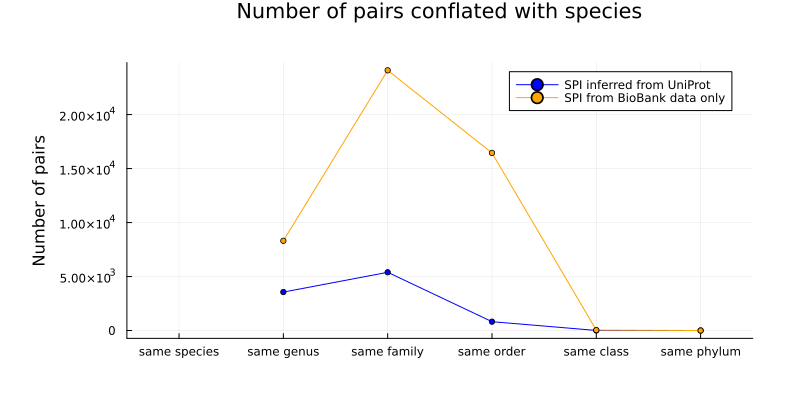

In [37]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum"];
plot(size=(800,400), title="Number of pairs conflated with species", ylabel="Number of pairs", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:6, labels),
    xlims=(.5, 6.5),
    # legend=:none,
)
plot!(2:6, 
    c=[:blue :orange],
    reshape(Nconflated, (5,length(methodsmatrices))), 
    label=["SPI inferred from UniProt" "SPI from BioBank data only" ], 
    lw=1, markersize=3, marker=true)

In [38]:
savefig(joinpath(pdir, "counts_of_pairs_conflated_with_species_by_distancemethod.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy/counts_of_pairs_conflated_with_species_by_distancemethod.pdf"

In [39]:
ydata1 = SPImtx ./ maximum(SPImtx)
ydata2 = BBSPImtx ./ maximum(BBSPImtx)

allspeciesdists = ydata1[uppertriangle][taxanomicdistance[uppertriangle].==0]
allspeciesdists2 = ydata2[uppertriangle][taxanomicdistance[uppertriangle].==0]

threshold = mean(allspeciesdists)+1.5std(allspeciesdists)

allorderdists = ydata1[uppertriangle][taxanomicdistance[uppertriangle].==3]
allorderdists2 = ydata2[uppertriangle][taxanomicdistance[uppertriangle].==3];

In [40]:
BB673pairs_UPcontext = intersect(findall(<(threshold), ydata1), findall(==(4), taxanomicdistance))
BB673pairs_BBcontext = intersect(findall(<(threshold), ydata2), findall(==(4), taxanomicdistance));

In [41]:
BB673pairs_UPcontext |> length, BB673pairs_BBcontext |> length, intersect(BB673pairs_BBcontext, BB673pairs_UPcontext) |> length, 78-10

(10, 78, 10, 68)

In [42]:
BB673pairs_UPcontext |> length, BB673pairs_BBcontext |> length, intersect(BB673pairs_BBcontext, BB673pairs_UPcontext) |> length

(10, 78, 10)

In [43]:
(1640 - 1354) / 2, (30406 - 1354) / 2, 1354 /2, 30406 / 2

(143.0, 14526.0, 677.0, 15203.0)

In [44]:
unique(getindex.(BB673pairs_UPcontext, 1)) |> length

6

In [45]:
unique(getindex.(BB673pairs_BBcontext, 1)) |> length

13

In [46]:
biobank.obs_names[unique(getindex.(BB673pairs_BBcontext, 1))]

13-element Vector{String}:
 "DFI.1.4_Anaerostipes_caccae"
 "DFI.1.3_Anaerostipes_caccae"
 "DFI.1.5_Anaerostipes_caccae"
 "DFI.1.94_Anaerostipes_caccae"
 "DFI.1.19_Anaerostipes_caccae"
 "DFI.1.13_Anaerostipes_caccae"
 "MSK.15.233_Lachnospiraceae_bacterium_EP-SM-12S-S03"
 "DFI.3.107_Lachnospiraceae_bacterium_210521-DFI.3.107"
 "MSK.1.24_Sellimonas_intestinalis"
 "MSK.1.25_Sellimonas_intestinalis"
 "MSK.1.19_Sellimonas_intestinalis"
 "MSK.1.20_Sellimonas_intestinalis"
 "MSK.1.21_Sellimonas_intestinalis"

In [47]:
biobank.obs[unique(getindex.(BB673pairs_BBcontext, 1)), 2:end]

13×6 DataFrame
 Row │ class       order          family            genus                      ⋯
     │ String      String         String            String                     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes               ⋯
   2 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   3 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   4 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   5 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes               ⋯
   6 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   7 │ Clostridia  Clostridiales  Lachnospiraceae   unclassified Lachnospirace
   8 │ Clostridia  Clostridiales  Lachnospiraceae   Mediterraneibacter
   9 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella              ⋯
  10 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella
  11 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella
  12 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella
  13 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella              ⋯
                                                               3 columns omitted

In [48]:
speciescontacts = [ones(Int, 6,6) zeros(Int, 6,7);
 zeros(Int, 2,6) diagm([1,1]) zeros(Int, 2,5);
 zeros(Int, 5,8) ones(Int, 5,5);
] * 2;

conflated_species_idx = unique(getindex.(BB673pairs_BBcontext,1))
diffmtx = Int.(ydata1[conflated_species_idx, conflated_species_idx] .< threshold)  .+ # up context
    Int.(ydata2[conflated_species_idx, conflated_species_idx] .< threshold)  .- # bb context
    speciescontacts # pairs that should be below threshold

13×13 Matrix{Int64}:
 0  0  0  0  0  0  0  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  0  2  2  2  2  2
 1  0  1  0  1  0  0  0  1  1  1  0  1
 1  1  1  1  1  1  2  1  0  0  0  0  0
 1  1  1  1  1  1  2  1  0  0  0  0  0
 1  1  1  1  1  1  2  1  0  0  0  0  0
 1  1  1  1  1  1  2  0  0  0  0  0  0
 1  1  1  1  1  1  2  1  0  0  0  0  0

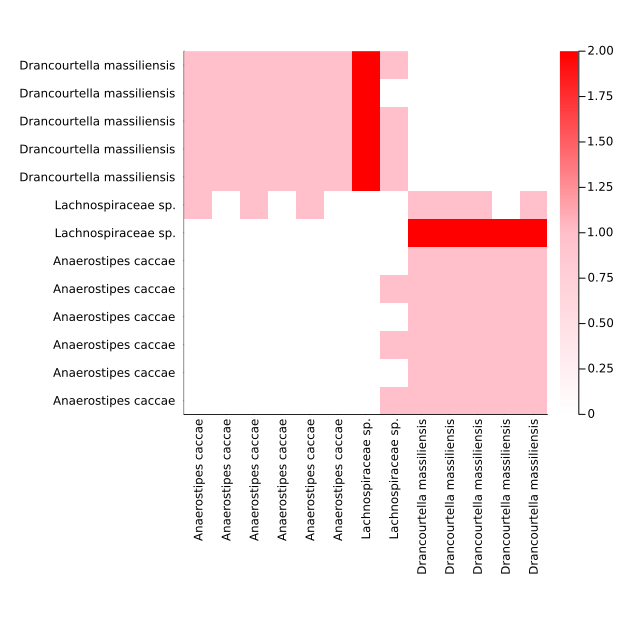

In [49]:
plot(
    yticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xrotation = 90,
    ratio=1,
    size=(630,630),
    margin=3Plots.Measures.mm,
)
heatmap!(diffmtx, 
    c=[:white, :pink, :red], 
    # clims=(-maximum(extrema(diffmtx)), maximum(extrema(diffmtx))),
)

In [50]:
savefig(joinpath(pdir, "Pairs_conflated_at_class_combined_heatmap.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy/Pairs_conflated_at_class_combined_heatmap.pdf"

In [51]:
splitdiffmtx = .-(tril(diffmtx) .> 1) + (triu(diffmtx) .> 0)

13×13 Matrix{Int64}:
 0  0  0  0  0  0   0  1  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  1  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  1  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  0  1
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0

In [52]:
sum(splitdiffmtx .== -1)

5

In [53]:
sum(splitdiffmtx .== 1)

42

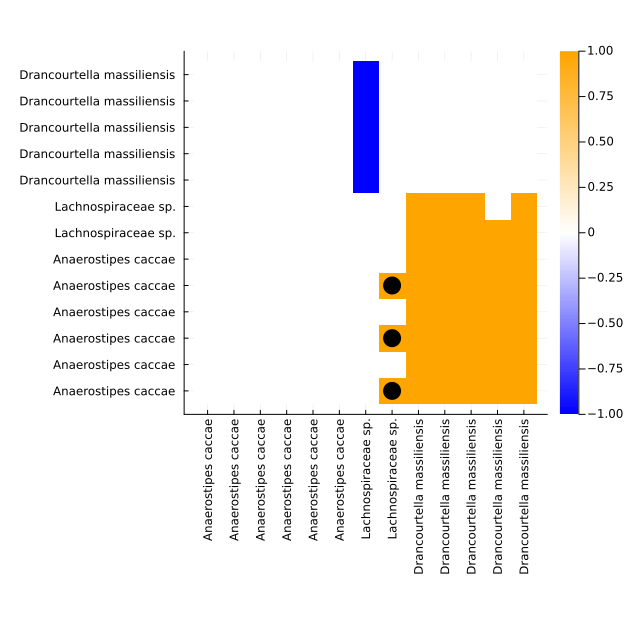

In [54]:
plot(
    yticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xrotation = 90,
    ratio=1,
    size=(630,630),
    margin=3Plots.Measures.mm,
)
heatmap!(.-(tril(diffmtx) .> 1) + (triu(diffmtx) .> 0),
    c=[:blue, :white, :orange])
scatter!([(8,1), (8, 3), (8,5)], c=:black, label=:none, markersize=10)

In [55]:
savefig(joinpath(pdir, "Pairs_conflated_at_class_heatmap_split_on_diagonal.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy/Pairs_conflated_at_class_heatmap_split_on_diagonal.pdf"

In [69]:
ifelse.(diffmtx .== 2, 1, NaN)

13×13 Matrix{Real}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    1    1    1    1    1
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  NaN  NaN

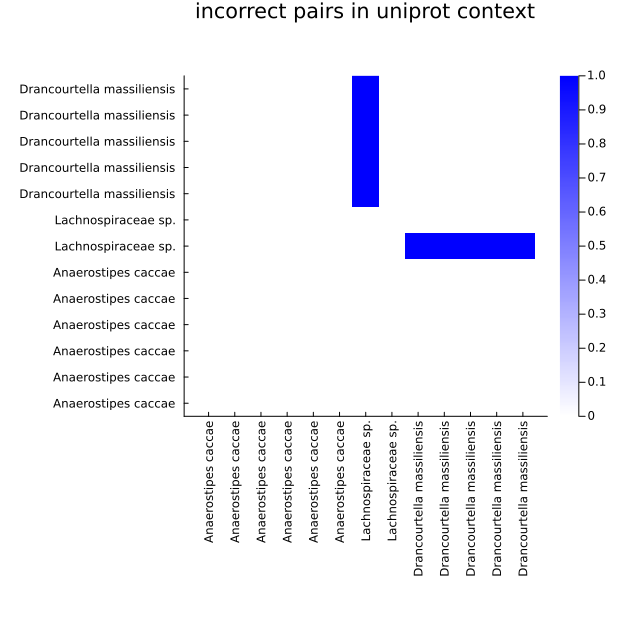

In [82]:
plot(
    title="incorrect pairs in uniprot context",
    yticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xrotation = 90,
    ratio=1,
    size=(630,630),
    margin=3Plots.Measures.mm,
    grid=false,
)
# scatter!([(8,1), (8, 3), (8,5)], c=:black, label=:none, markersize=10)
heatmap!(ifelse.(diffmtx .== 2, 1, NaN), c=[:white, :blue])

In [83]:
savefig(joinpath(pdir, "Pairs-conflated-at-class-uniprot-context_heatmap.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy/Pairs-conflated-at-class-uniprot-context_heatmap.pdf"

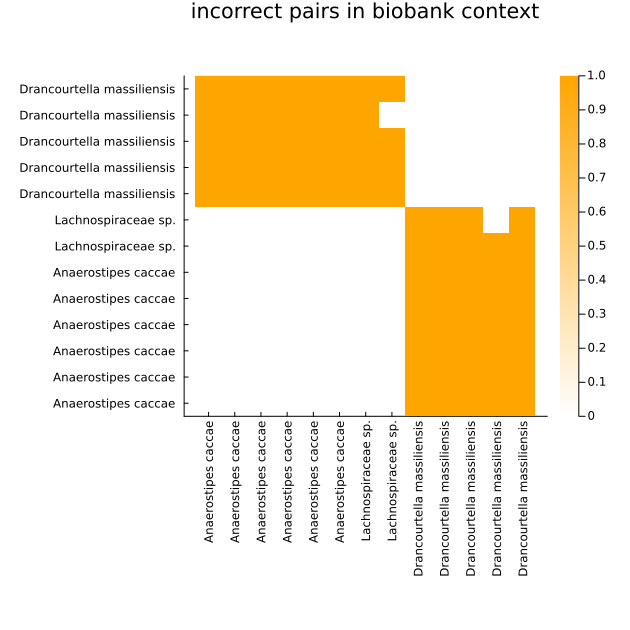

In [94]:
pbbmtx = ifelse.(diffmtx .>= 1, 1, NaN)
for (i, j) in [(8,1), (8, 3), (8,5)]
    pbbmtx[i,j] = NaN
    pbbmtx[j,i] = NaN
end
plot(
    title="incorrect pairs in biobank context",
    yticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xrotation = 90,
    ratio=1,
    size=(630,630),
    margin=3Plots.Measures.mm,
    grid=false,
)
heatmap!(pbbmtx, c=[:white, :orange])

In [95]:
savefig(joinpath(pdir, "Pairs-conflated-at-class_biobank-context_heatmap.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy/Pairs-conflated-at-class_biobank-context_heatmap.pdf"

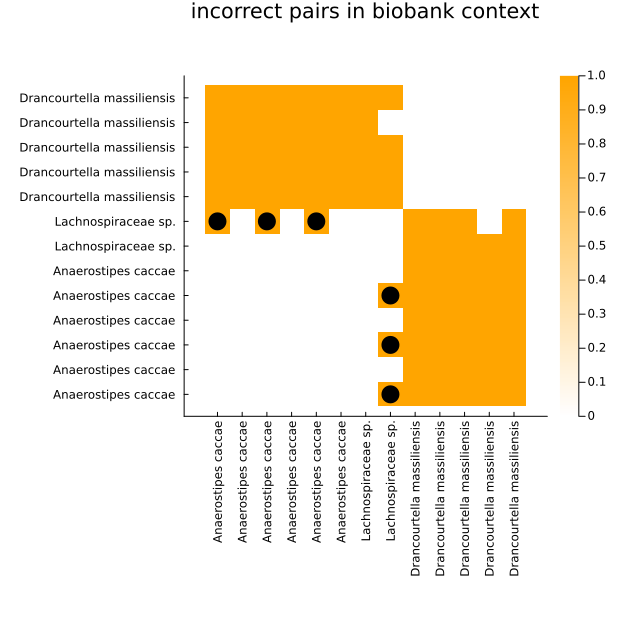

In [98]:
plot(
    title="incorrect pairs in biobank context",
    yticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xrotation = 90,
    ratio=1,
    size=(630,630),
    margin=3Plots.Measures.mm,
    grid=false,
)
heatmap!(ifelse.(diffmtx .>= 1, 1, NaN), c=[:white, :orange])
scatter!([(8,1), (8, 3), (8,5)], c=:black, label=:none, markersize=10)
scatter!([(1, 8), (3, 8), (5, 8)], c=:black, label=:none, markersize=10)

In [99]:
savefig(joinpath(pdir, "Pairs-conflated-at-class_biobank-context_plusfamilyincorrectnessofthesespecies_heatmap.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots_taxonomy/Pairs-conflated-at-class_biobank-context_plusfamilyincorrectnessofthesespecies_heatmap.pdf"

# Other violin plots

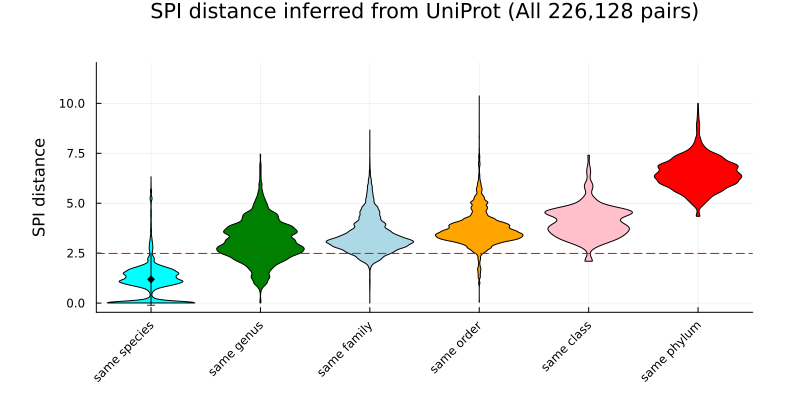

In [56]:
n = 6
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="SPI distance inferred from UniProt (All 226,128 pairs)", ylabel="SPI distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:n, labels[1:n]),
    xlims=(.5, n +.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = SPImtx
for i in 0:n
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
# savefig(joinpath(pdir, "SPIdistUP_groupedby_NCBItaxonomy_violin.pdf"))
savefig(joinpath(pdir, "SPIdistUP_groupedby_NCBItaxonomy_6mainlevels_violin.pdf"))

In [ ]:
n = 6
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="SPI distance using BioBank data only (All 226,128 pairs)", ylabel="SPI distance ", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:n, labels),
    xlims=(.5, n + .5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = BBSPImtx
for i in 0:n-1
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
# savefig(joinpath(pdir, "SPIdistBB_groupedby_NCBItaxonomy_violin.pdf"))
savefig(joinpath(pdir, "SPIdistBB_groupedby_NCBItaxonomy_6mainlevels_violin.pdf"))

In [ ]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="Euclidean distance of top 10 BioBank PCs (All 226,128 pairs)", ylabel="Euclidean distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = BBsvdeuclideandistance
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
savefig(joinpath(pdir, "BBsvdeuclidean_groupedby_NCBItaxonomy_violin.pdf"))

In [ ]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="Euclidean of top 10 inferred UniProt PCs (All 226,128 pairs)", ylabel="Euclidean distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = UPsvdeuclideandistance
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
savefig(joinpath(pdir, "UPsvdeuclidean_groupedby_NCBItaxonomy_violin.pdf"))